<a href="https://www.kaggle.com/code/martinvelkov/digit-recognizer?scriptVersionId=141071860" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

train.shape, test.shape

((42000, 785), (28000, 784))

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
n_train = train.shape[0]

X = pd.concat([train.drop('label', axis=1), test], axis=0).astype('float32')
y = train['label'].astype('int32')

X.shape, y.shape

((70000, 784), (42000,))

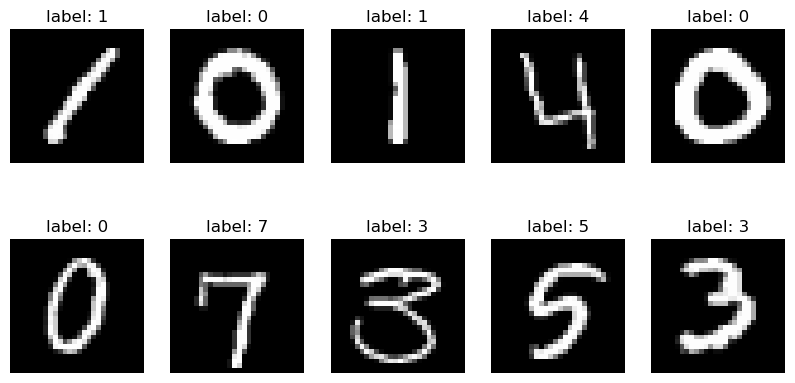

In [5]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X.values[i].reshape(28, 28), cmap='gray')
    plt.title(f'label: {y[i]}')
    plt.axis('off')
plt.show()

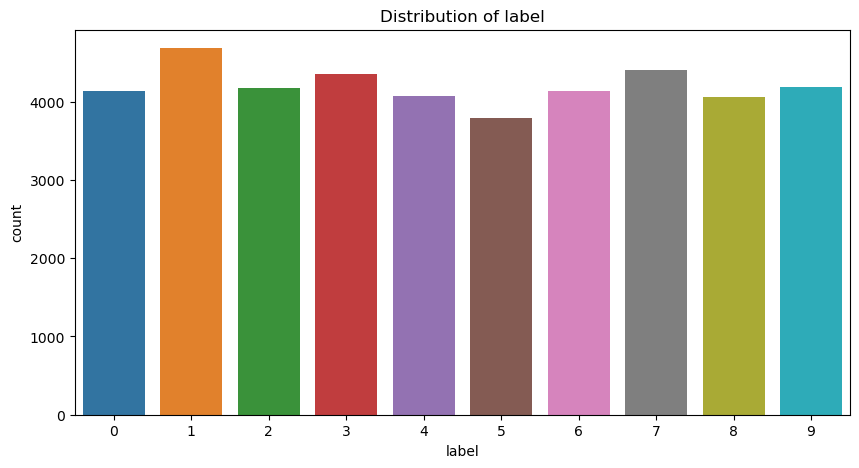

In [6]:
plt.figure(figsize=(10, 5))
plt.title('Distribution of label')
sns.countplot(data=y.to_frame(), x='label')
plt.show()

In [7]:
pd.DataFrame(X.isnull().sum(), columns=['missing pixels']).sort_values(by='missing pixels', ascending=False).head()

,missing pixels
pixel0,0
pixel515,0
pixel517,0
pixel518,0
pixel519,0


In [8]:
pd.DataFrame(y, columns=['missing labels']).isnull().sum()

missing labels    0.0
dtype: float64

In [9]:
X /= 255.0

In [10]:
X = X.values.reshape(-1, 28, 28, 1)

X.shape

(70000, 28, 28, 1)

In [11]:
y = tf.keras.utils.to_categorical(y, num_classes=10)

y.shape

(42000, 10)

In [12]:
X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]

X_train.shape, y_train.shape, X_test.shape

((42000, 28, 28, 1), (42000, 10), (28000, 28, 28, 1))

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=True, stratify=y_train)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((37800, 28, 28, 1), (37800, 10), (4200, 28, 28, 1), (4200, 10))

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding="same", activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, (5, 5), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)

In [17]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    vertical_flip=False,
    horizontal_flip=False
)

In [18]:
datagen.fit(X_train)

In [19]:
batch_size = 128
epochs = 30
steps_per_epoch = X_train.shape[0] // batch_size

In [20]:
train_gen = datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True, seed=42)
val_gen = datagen.flow(X_val, y_val, batch_size=batch_size, shuffle=True, seed=42)

In [21]:
history = model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=val_gen, callbacks=[reduce_lr])

Epoch 1/30


2023-08-26 11:58:52.652974: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


295/295 [==============================] - 28s 51ms/step - loss: 0.3052 - accuracy: 0.9019 - val_loss: 0.9075 - val_accuracy: 0.6926 - lr: 0.0010
Epoch 2/30
295/295 [==============================] - 15s 51ms/step - loss: 0.0962 - accuracy: 0.9705 - val_loss: 0.0542 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 3/30
295/295 [==============================] - 14s 48ms/step - loss: 0.0732 - accuracy: 0.9774 - val_loss: 0.0732 - val_accuracy: 0.9786 - lr: 0.0010
Epoch 4/30
295/295 [==============================] - 15s 50ms/step - loss: 0.0617 - accuracy: 0.9812 - val_loss: 0.0740 - val_accuracy: 0.9774 - lr: 0.0010
Epoch 5/30
295/295 [==============================] - 14s 49ms/step - loss: 0.0513 - accuracy: 0.9845 - val_loss: 0.0532 - val_accuracy: 0.9855 - lr: 0.0010
Epoch 6/30
295/295 [==============================] - 14s 48ms/step - loss: 0.0472 - accuracy: 0.9858 - val_loss: 0.0465 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 7/30
295/295 [==============================] - 14s 47ms/step -

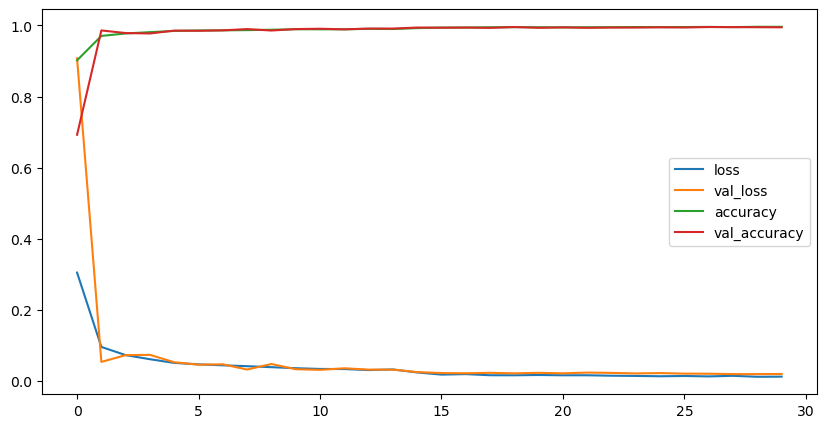

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [23]:
y_pred = model.predict(X_test)

875/875 [==============================] - 2s 2ms/step


In [24]:
submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submission['Label'] = y_pred.argmax(axis=1)

In [25]:
submission.to_csv('/kaggle/working/submission.csv', index=False)